In [23]:
%matplotlib inline

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from nose.tools import *

import geopandas as gpd
import geodatasets

from shapely.geometry import Point

import networkx as nx

# Working with Spatial Data and Networks Lab
## Preparing data, extracting features, visualization and modelling

In this lab we'll explore terrorism, as described in [this](https://www.kaggle.com/START-UMD/gtd) dataset.

The full codebook, describing all variables, their values, the data collection process, and many more details, is located [here](http://start.umd.edu/gtd/downloads/Codebook.pdf).

We'll perform our usual process:
* Reading and inspecting the data
* Validating the data
* Exploring the data
* Creating inferences and getting to conclusions

### Problem 1. Read the dataset (1 point)
The dataset is provided in the `data` folder. Read it into Python. You'll likely get an encoding error, so you can use `encoding = "cp1252"`.

Use the column `eventid` as the index, since this is a good unique identifier and it's used in the dataset (e.g. the column `related` contains the `eventid` of all related crimes).

You'll see the dataset has a lot of columns. For this lab, we aren't going to need all of them, only a few. Select these columns (and rename them as described in the tests below):
* eventid
* iyear, imonth, iday
* country_txt
* region_txt
* multiple (1 if it's a part of a multiple incident and 0 otherwise)
* latitude, longitude
* targtype1_txt (first target type)
* weaptype1_txt (weapon type)
* gname (perpetrator group name)
* nkill (total number of fatalities)
* related (IDs of the related incidents)

You'll have a total of 13 columns (the eventid which will become an index is not considered a typical column in a dataframe) and just over 170 thousand records.

In [25]:
terrorism_data = pd.read_csv("data/globalterrorismdb.csv", encoding = "cp1252", low_memory=False, index_col="eventid")
# select columns
terrorism_data = terrorism_data[["iyear", "imonth", "iday", "country_txt", "region_txt", "multiple", "latitude", "longitude", "targtype1_txt", "weaptype1_txt", "gname", "nkill", "related"]]
#rename columns
terrorism_data.columns = ["year", "month", "day", "country", "region", "multiple", "latitude", "longitude", "target_type", "weapon_type", "group_name", "fatalities", "related"]
terrorism_data.head()

,year,month,day,country,region,multiple,latitude,longitude,target_type,weapon_type,group_name,fatalities,related
eventid,,,,,,,,,,,,,
197000000001,1970,7,2,Dominican Republic,Central America & Caribbean,0,18.456792,-69.951164,Private Citizens & Property,Unknown,MANO-D,1.0,NaN
197000000002,1970,0,0,Mexico,North America,0,19.432608,-99.133207,Government (Diplomatic),Unknown,23rd of September Communist League,0.0,NaN
197001000001,1970,1,0,Philippines,Southeast Asia,0,15.478598,120.599741,Journalists & Media,Unknown,Unknown,1.0,NaN
197001000002,1970,1,0,Greece,Western Europe,0,37.983773,23.728157,Government (Diplomatic),Explosives/Bombs/Dynamite,Unknown,NaN,NaN
197001000003,1970,1,0,Japan,East Asia,0,33.580412,130.396361,Government (Diplomatic),Incendiary,Unknown,NaN,NaN


In [26]:
assert_is_not_none(terrorism_data)
assert_list_equal(terrorism_data.columns.tolist(), ["year", "month", "day", "country", "region", "multiple", "latitude", "longitude", "target_type", "weapon_type", "group_name", "fatalities", "related"])

NameError: name 'assert_is_not_none' is not defined

### Problem 2. Convert columns (1 point)
Convert the "year", "month" and "day" columns into a single date. Call the new column "date".

Note that some months and/or days contain 0 as their values. This means that the exact month or day is not present or known. In these cases, write "not a time" (NaT) values in the "date" column. Do not remove those records!

Also, convert the "multiple" column into a Boolean one.

In [27]:
terrorism_data.month.replace(0, pd.NaT, inplace=True)  #replace 0 values with  "not a time" value
terrorism_data.day.replace(0, pd.NaT, inplace=True)
# create a "date" column and drop "year", "month", "day" columns
terrorism_data["date"] = pd.to_datetime(terrorism_data[["year", "month", "day"]], errors='coerce')
terrorism_data.drop(columns=["year", "month", "day"], inplace=True)
date_column = terrorism_data.pop("date")
terrorism_data.insert(0, "date", date_column)

terrorism_data["multiple"] = terrorism_data.multiple.astype("bool")  #convert to boolean type
terrorism_data.head()

,date,country,region,multiple,latitude,longitude,target_type,weapon_type,group_name,fatalities,related
eventid,,,,,,,,,,,
197000000001,1970-07-02,Dominican Republic,Central America & Caribbean,False,18.456792,-69.951164,Private Citizens & Property,Unknown,MANO-D,1.0,NaN
197000000002,NaT,Mexico,North America,False,19.432608,-99.133207,Government (Diplomatic),Unknown,23rd of September Communist League,0.0,NaN
197001000001,NaT,Philippines,Southeast Asia,False,15.478598,120.599741,Journalists & Media,Unknown,Unknown,1.0,NaN
197001000002,NaT,Greece,Western Europe,False,37.983773,23.728157,Government (Diplomatic),Explosives/Bombs/Dynamite,Unknown,NaN,NaN
197001000003,NaT,Japan,East Asia,False,33.580412,130.396361,Government (Diplomatic),Incendiary,Unknown,NaN,NaN


In [28]:
assert_greater(len(terrorism_data.date), 0)
assert_equal(terrorism_data.multiple.dtype, np.bool)

NameError: name 'assert_greater' is not defined

### Problem 3. Show how the number of attacks evolves with time (1 point)
Group all incidents by year. Create a line plot showing how the attacks evolve.

Create a function which accepts a dataframe and returns the years with minimum and maximum incidents.

Use this function to see the numbers for your dataset.

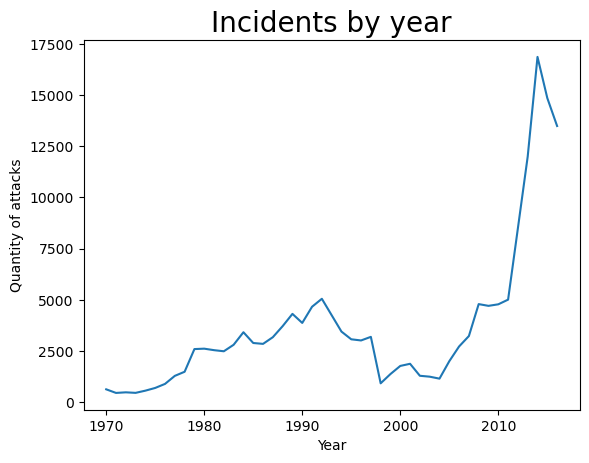

In [29]:
attacks_by_year = terrorism_data.groupby(terrorism_data.date.dt.year).date.count()
attacks_by_year.plot()
plt.title("Incidents by year", fontsize=20)
plt.xlabel("Year")
plt.ylabel("Quantity of attacks")
plt.show()

In [30]:
def get_max_and_min_incidents_years(dataframe):
    group_by_year = dataframe.groupby(dataframe.date.dt.year).date.count()
    
    min_incidents_year = group_by_year[group_by_year == group_by_year.min()]
    max_incidents_year = group_by_year[group_by_year == group_by_year.max()]
    
    min_incidents_year = int(min_incidents_year.index[0])
    max_incidents_year = int(max_incidents_year.index[0])
   
    return (min_incidents_year, max_incidents_year)

In [31]:
min_year, max_year = get_max_and_min_incidents_years(terrorism_data)
assert_equal(min_year, 1971)
assert_equal(max_year, 2014)

NameError: name 'assert_equal' is not defined

In [32]:
min_year, max_year = get_max_and_min_incidents_years(terrorism_data)
print(min_year, max_year)

1971 2014


### Problem 4. Filter terror attacks (1 point)
Get only recent attacks (from 1 Jan 2000 onwards, inclusive). Save them in the variable `recent_attacks`.

Create another variable which contains attacks before that. Call that `older_attacks`.

We'll compare these later.

In [33]:
recent_attacks = terrorism_data[terrorism_data["date"] >= "2000-01-01"]
older_attacks = terrorism_data[terrorism_data["date"] < "2000-01-01"]

In [34]:
assert_is_not_none(recent_attacks)
assert_is_not_none(older_attacks)

NameError: name 'assert_is_not_none' is not defined

### Problem 5. Compare recent to older attacks (1 point)
Create a function which accepts a dataframe and returns a `Series`. The index should be a country name, and the values should be the number of  attacks. Sort the values from highest to lowest.

In [38]:
def get_num_attacks_by_country(dataframe):
    attacks_per_country = dataframe.groupby(dataframe.country).size()
    attacks_per_country = attacks_per_country.sort_values(ascending=False).nlargest(10)
    
    return attacks_per_country

In [39]:
recent_attacks_by_country = get_num_attacks_by_country(recent_attacks)
older_attacks_by_country = get_num_attacks_by_country(older_attacks)
print(recent_attacks_by_country)
print(older_attacks_by_country)
assert_equal(recent_attacks_by_country.shape, (10,))
assert_equal(older_attacks_by_country.shape, (10,))

country
Iraq           21951
Pakistan       11782
Afghanistan    11169
India           7916
Philippines     4218
Thailand        3437
Nigeria         3337
Somalia         3305
Yemen           3001
Libya           2039
dtype: int64
country
Colombia          6160
Peru              5986
El Salvador       5277
United Kingdom    4144
India             3033
Spain             2793
Turkey            2466
United States     2327
Chile             2262
France            2189
dtype: int64


NameError: name 'assert_equal' is not defined

In [40]:
recent_attacks_by_country = get_num_attacks_by_country(recent_attacks)
older_attacks_by_country = get_num_attacks_by_country(older_attacks)
print(recent_attacks_by_country)
print(older_attacks_by_country)

country
Iraq           21951
Pakistan       11782
Afghanistan    11169
India           7916
Philippines     4218
Thailand        3437
Nigeria         3337
Somalia         3305
Yemen           3001
Libya           2039
dtype: int64
country
Colombia          6160
Peru              5986
El Salvador       5277
United Kingdom    4144
India             3033
Spain             2793
Turkey            2466
United States     2327
Chile             2262
France            2189
dtype: int64


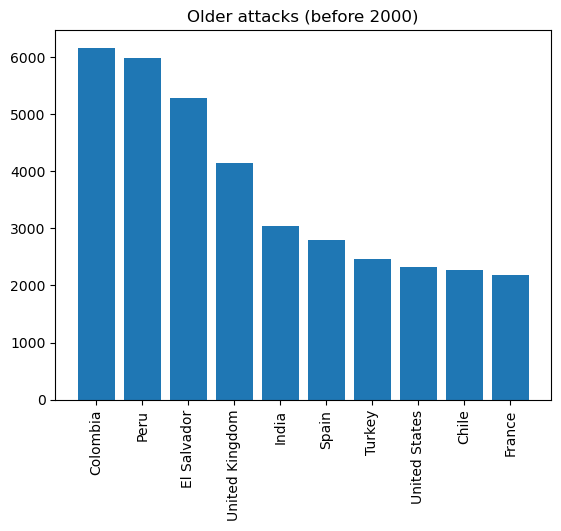

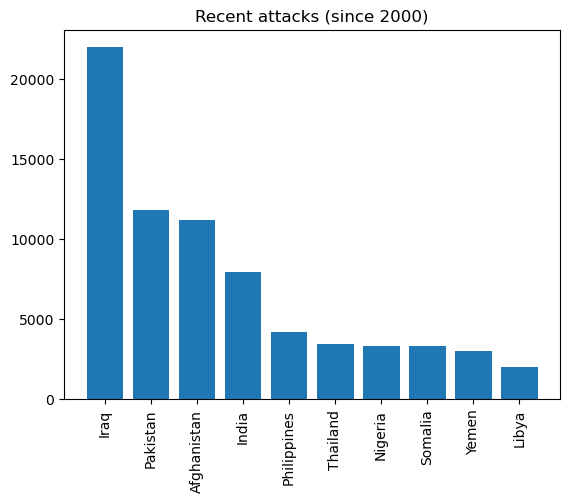

In [41]:
def show_graph(num_attacks, title):
    plt.bar(range(len(num_attacks)), num_attacks)
    plt.xticks(range(len(num_attacks)), num_attacks.index, rotation = "vertical")
    plt.title(title)
    plt.show()

show_graph(older_attacks_by_country, "Older attacks (before 2000)")
show_graph(recent_attacks_by_country, "Recent attacks (since 2000)")

We can see that these attacks definitely changed very much. First, there are many more since 2000, and second, the top targeted countries have changed a lot: only India remains in the top chart (execute the following cell if you don't believe me).

In [42]:
set(recent_attacks_by_country.index).intersection(set(older_attacks_by_country.index))

{'India'}

There's a lot more to explore in the data, but let's focus on the spatial aspect.

### Problem 6. Create a basic map (2 points)
Plot all places where terrorist attacks have occurred.

The skeleton below almost does the job. What you need to do is: first, assign the proper coordinates to the `x` and `y` variables and use them as `Point`s; second, assign the points to the `geometry` feature in the dataset (think about a possible data type conversions); and third, create a scatter plot, using a red circle (`"o"`), with marker size 1.

In [ ]:
land = gpd.read_file(geodatasets.data.naturalearth.land.url)

fig = plt.figure(figsize = (12, 8))
ax = fig.gca()
land.plot(ax = ax, color = "green")
ax.set_facecolor("aqua")

x = terrorism_data.longitude
y = terrorism_data.latitude
geometry = [Point(point) for point in zip(x, y)]
terrorism_geodata = gpd.GeoDataFrame(data=terrorism_data, geometry=geometry)

# Set the CRS of terrorism_geodata to match the CRS of the land GeoDataFrame
terrorism_geodata.crs = land.crs

terrorism_geodata.plot(ax=ax, marker='o', markersize=1, color='red')

plt.show()

In [ ]:
assert_is_not_none(x)
assert_is_not_none(y)


### Problem 7. Emphasize incidents which are part of a group (0 points)
Redraw the map above. This time, filter out the attacks which are part of a series (this is contained in the column `multiple`). Show them on the map with an orange color.

In [ ]:
# Note: This is not autograded
single_attacks = None
multiple_attacks = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
fig = plt.figure(figsize = (12, 8))
ax = fig.gca()
land.plot(ax = ax, color = "green")
ax.set_facecolor("aqua")

single_attacks.plot(ax = ax, c = "r", marker = "o", markersize = 1)
multiple_attacks.plot(ax = ax, c = "orange", marker = "o", markersize = 1)
plt.show()

You can see that a lot of the attacks are parts of series, possibly organized. But, remember that we have a point on the map for every single attack. If we see how many multiple attacks there are (as a fraction of the whole), we'll get about 13.4%:

In [ ]:
len(multiple_attacks) / len(terrorism_data)

The plot we made was a little misleading. We're displaying where attacks occur but we omitted the "density" of attacks: each location gets a point no matter whether there was one incident, or ten thousand in that point. 

We can try plotting the densities instead.

### Problem 8. Plot attack densities (1 point)
First, we need to filter out attacks with unknown (NaN) location. Do this and save it in the variable `attacks_with_locations`.

The following cell prints a 2D histogram (also called a heatmap) over the world map. Execute it, it should run just fine.

In [ ]:
attacks_with_locations = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
def plot_attack_densities(attack_data, title = "Attack densities", num_bins = 100):
    # Prepare histogram bins
    lon_bins = np.linspace(-180, 180, num_bins + 1)
    lat_bins = np.linspace(-90, 90, num_bins + 1)
    
    # Prepare 2D histogram
    density, x_breaks, y_breaks = np.histogram2d(
        attack_data.latitude,
        attack_data.longitude, 
        [lat_bins, lon_bins])
    lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)
    
    fig = plt.figure(figsize = (15, 10))
    ax = plt.gca()
    mesh = ax.pcolormesh(lon_bins_2d, lat_bins_2d, density)
    plt.colorbar(mesh, fraction = 0.025, ax = ax)
    land.boundary.plot(ax = ax, edgecolor = "k")
    ax.set_title(title)

    plt.show()

In [ ]:
plot_attack_densities(attacks_with_locations)

We can see various "hot points". The hottest one, as expected from the data above, is Iraq. Actually, it has so many attacks that it overshadows most of the data in our dataset.

Let's remove it and plot the data again. This is a way to estimate **importance** of something (although not a very scientific one :)).

In [ ]:
attacks_without_iraq = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert_is_not_none(attacks_with_locations)
assert_is_not_none(attacks_without_iraq)

In [ ]:
plot_attack_densities(attacks_without_iraq, "Attack densities (Iraq omitted)")

Well, the map "lit up". Notice that the colorbar now shows completely different values.

Based on these visualizations, we can conclude that the number of attacks in Iraq is really significant compared to all others.

We're also able to see more hot points now, and we may try to interpret them. However, that's not what we're going to do.

### Problem 9. Create a graph of connected incidents (1 + 1 points)
We already have incidents which are part of groups: the variable `multiple_attacks` holds them.

However, it turns out that some of these hold NaNs in the `related` column.

Create a new dataset which holds the `eventid` and `related` incidents of every attack in `multiple_attacks`.

Filter the dataset so that it contains only valid (i.e. non-empty or NaN) `related` values.

Store this dataset into `incident_relations`.

In [ ]:
incident_relations = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert_equal(incident_relations.shape, (22840, 1))

Get all relations by splitting the column first, like so:
```
relations = incident_relations.related.str.split(", ")
```

For each relation, if the id of the first and second node aren't the same, add the relation as an edge. An edge has the format `(id_1, id_2)`.

The code is not very hard to understand but it definitely IS tricky to write. So I'm giving it to you for free :).

In [ ]:
edges = set()

relations = incident_relations.related.str.split("\D+")
for index, related in relations.iteritems():
    current_index = int(index)
    for related_id in related:
        if related_id != "":
            current_related = int(related_id)
            # (id_1, id_2) and (id_2, id_1) should be considered the same
            # undirected edge but in the dataset, they are separate
            # so we need to avoid double-adding edges
            if current_index == current_related:
                continue
            elif current_index > current_related:
                current_index, current_related = current_related, current_index
            edges.add((current_index, current_related))
print(len(edges))

Create a graph, `attack_graph` and add all edges that you (or I :D) just calculated to it.

Beware: visualization will take a lot of time, so **don't do that** (or just comment it out before submitting). I'm only testing basic properties on the graph.

In [ ]:
attack_graph = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert_is_not_none(attack_graph)